In [164]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import nltk
# from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import regex as re
# from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords # import stopwords
from bs4 import BeautifulSoup  


### Data Cleaning & EDA

In [165]:
# Read in IndianFood df and create copy
indian_food = pd.read_csv('../data/IndianFood.csv')

# Create copy
ifdf = indian_food.copy()

# Preview
ifdf.head()

,Titles,Subreddit
0,Help needed!,IndianFood
1,Sheer Khurma Recipe in Hindi | How to make She...,IndianFood
2,Green revolution in india,IndianFood
3,Food grain production in india fy 19-20,IndianFood
4,Has anyone tried making red curry paste in the...,IndianFood


In [166]:
# Read in Whole30 df and make copy
whole30 = pd.read_csv('../data/whole30.csv')

# Create copy
w3df = whole30.copy()

# Preview
w3df.head()

,Titles,Subreddit
0,My meal prep for the week! I was excited to tr...,whole30
1,"Tips for someone who succeeded once, then fail...",whole30
2,Will this diet help me?,whole30
3,"/r/Whole30 Daily Update Thread - May 24, 2020",whole30
4,R1D14: Needed a quick and light lunch! Slice o...,whole30


In [167]:
# Concatenate dataframes
df = pd.concat([ifdf, w3df])
df.shape

(27152, 2)

In [168]:
# Check dtypes
df.dtypes

Titles       object
Subreddit    object
dtype: object

In [169]:
# Check for Null
df.isnull().sum()

Titles       0
Subreddit    0
dtype: int64

In [170]:
# Locate Titles with http (threw error in modeling)

df[df['Titles'].str.contains('http')]

,Titles,Subreddit
221,https://youtu.be/ubtWnVIO--g,IndianFood
228,Hello. I wanna start eating healthy so I decid...,IndianFood
451,[Foodiemerikismat](https://www.instagram.com/f...,IndianFood
452,[foodiemerikismat](https://www.instagram.com/p...,IndianFood
460,South Indian Pepper Rasam Recipe Very Easy Mak...,IndianFood
...,...,...
8138,Made whole 30 approved pulled pork on my WSM. ...,whole30
8787,Whole 30 Shepard's Pie! R1D10M3. Excuse the ph...,whole30
9521,Haddock breaded with flaxseed crackers over tu...,whole30
9951,I'm spoiling myself with this amazing soup for...,whole30


In [171]:
# Get indices for row containing http/url

indices = df[df['Titles'].str.contains('http')].index
indices

Int64Index([  221,   228,   451,   452,   460,   609,   626,   821,   828,
             1144,  1742,  1743,  1958,  2545,  2578,  2687,  2997,  3015,
             3050,  3105,  3375,  3599,  3749,  3820,  3826,  3977,  4018,
             4053,  4061,  4063,  4340,  4450,  4634,  4678,  4732,  4739,
             4746,  4813,  4936,  5792,  5793,  6607,  7468,  7489,  7635,
             7882,  7883,  8037,  8093,  8591,  8875,  8932,  8971,  9067,
             9211,  9299,  9335,  9413,  9648, 10058, 10059, 10380, 10523,
            11136, 11204, 11205, 12247, 12621, 13496, 14030,   171,   172,
              174,   314,   861,  1051,  1103,  3491,  4072,  4189,  4825,
             5363,  5509,  5541,  5638,  5726,  5966,  6492,  6493,  8138,
             8787,  9521,  9951, 11278],
           dtype='int64')

In [172]:
# Delete row indices from dataFrame

df.drop(indices, inplace=True)
df.shape

(26966, 2)

In [173]:
# Confirm drop

df[df['Titles'].str.contains('http')]

,Titles,Subreddit


### Natural Language Processing (NLP)

#### Train/Test/Split


In [174]:
# Convert subreddits to binary

df['Subreddit'] = df['Subreddit'].map({'IndianFood': 0, 'whole30': 1})
df.head()

,Titles,Subreddit
0,Help needed!,0
1,Sheer Khurma Recipe in Hindi | How to make She...,0
2,Green revolution in india,0
3,Food grain production in india fy 19-20,0
4,Has anyone tried making red curry paste in the...,0


In [175]:
# Assign variables
X = df[['Titles']]
y = df['Subreddit']

# Create split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [176]:
# Check shape prior to processing
X_train.shape

(18067, 1)

In [177]:
# Baseline
y.value_counts(normalize=True) #Baseline accuracy: 48.2%

0    0.517726
1    0.482274
Name: Subreddit, dtype: float64

#### NLP Cleaning

In [178]:
X_test['Titles'].head()

7310     Here's What a Perfect Indian Takeaway Menu Loo...
5353                             heavy on the sausage hash
10404                        Starting Whole 30 around 2017
12282                            Starting on 1st November.
1569                  R2D5 Lunch “Attack of the Leftovers”
Name: Titles, dtype: object

In [179]:
# function to get text and numbers only and remove stopwords

def title_to_words(raw_title):  
                                
    # Remove HTML and non-letters or non-numbers. Want to keep 30 for whole30.
    text_ltrs_nums = re.sub("[^a-zA-Z0-9_]", " ", BeautifulSoup(raw_title).get_text()) 
    
    # Create set of stopwords for efficient searching
    stops = set(stopwords.words('english'))
    
    # Remove stopwords
    meaningful_words = [w for w in text_ltrs_nums.lower().split() if w not in stops]
    
    # Join the words back into one string separated by space 
    return(" ".join(meaningful_words))

In [180]:
# Get the number of titles based on the dataframe size.
total_titles = df.shape[0]
print(f'There are {total_titles} titles.')

There are 26966 titles.


In [181]:
# Initialize an empty list to hold the cleaned titles
# Adapted from class lesson 5.03 code

clean_train_titles = []
clean_test_titles = []

# Message to indicate sequence has been initiated
print("Cleaning and parsing the training set Reddit submission titles...")

# Instantiate counter.
j = 0

# For loop to iterate through train titles
for train_title in X_train['Titles']:
    
    # Apply title_to_words function and append to clean_train_titles.
    clean_train_titles.append(title_to_words(train_title))
    
    # Track processing: If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Title {j + 1} of {total_titles}.')
    
    j += 1

# Message to indicate sequence has been initiated
print("Cleaning and parsing the testing set Reddit submission titles...")

# For loop to iterate through test titles
for test_title in X_test['Titles']:
    
    # Convert title to words, then append to clean_train_titles.
    clean_test_titles.append(title_to_words(test_title))
    
    # Track processing: If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Title {j + 1} of {total_titles}.')
        
    j += 1

Cleaning and parsing the training set Reddit submission titles...
Title 1000 of 26966.
Title 2000 of 26966.
Title 3000 of 26966.
Title 4000 of 26966.
Title 5000 of 26966.
Title 6000 of 26966.
Title 7000 of 26966.
Title 8000 of 26966.
Title 9000 of 26966.
Title 10000 of 26966.
Title 11000 of 26966.
Title 12000 of 26966.
Title 13000 of 26966.
Title 14000 of 26966.
Title 15000 of 26966.
Title 16000 of 26966.
Title 17000 of 26966.
Title 18000 of 26966.
Cleaning and parsing the testing set Reddit submission titles...
Title 19000 of 26966.
Title 20000 of 26966.
Title 21000 of 26966.
Title 22000 of 26966.
Title 23000 of 26966.
Title 24000 of 26966.
Title 25000 of 26966.
Title 26000 of 26966.


In [182]:
# Preview text
clean_train_titles[:3]

['r whole30 daily update thread january 08 2017',
 'favorite paleo whole 30 cookbook recipe source hartwig books',
 'knowledgeable indian food self proclaimed indian food expert get flair']

In [183]:
X_train.shape

(18067, 1)

In [184]:
y_train.shape

(18067,)

In [185]:
# Preview text
clean_test_titles[:3]

['perfect indian takeaway menu looks like',
 'heavy sausage hash',
 'starting whole 30 around 2017']

In [186]:
X_test.shape

(8899, 1)

In [187]:
y_test.shape

(8899,)

### Modeling

#### Logistic Regression - CountVectorizer - GridSearchCV

In [188]:
# Set up pipeline

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

In [189]:
# Set pipeline parameters

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [190]:
# Set up pipeline

gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5) 

In [191]:
# Fit GridSearch to training data.
gs.fit(clean_train_titles, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [192]:
# What's the best score?
gs.best_score_

0.9257763003334052

In [193]:
# Save best model as gs_model.
gs_model = gs.best_estimator_
gs_model

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                           

In [194]:
# View best parameters
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [195]:
# Score model on training set.

gs_train = gs_model.score(clean_train_titles, y_train)
print(f'GS Training Accuracy Score: {gs_train}')

GS Training Accuracy Score: 0.9645762993302707


In [196]:
# Score model on testing set.

gs_test = gs_model.score(clean_test_titles, y_test)
print(f'GS Testing Accuracy Score: {gs_test}')

GS Testing Accuracy Score: 0.934487021013597


#### Naive Bayes (Multinomial) - TFIDFVectorizer

In [197]:
# instantiate TfidfVectorizer
tvec = TfidfVectorizer() 

In [198]:
# fit and transform

vectors = tvec.fit_transform(clean_train_titles) 

vectors_test = tvec.transform(clean_test_titles)

In [199]:
# Confirm shapes match
vectors.shape[1] 

11623

In [200]:
# Confirm shapes match
vectors_test.shape[1]

11623

In [201]:
# Instantiante and git model

mnb_clr = MultinomialNB() 
mnb_clr.fit(vectors, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [202]:
# Generate prediction
mnb_clr.predict(vectors_test) 

array([0, 1, 1, ..., 0, 0, 1])

In [203]:
# Generate probabilities
mnb_clr.predict_proba(vectors_test)

array([[0.86588689, 0.13411311],
       [0.06511394, 0.93488606],
       [0.00591634, 0.99408366],
       ...,
       [0.90407805, 0.09592195],
       [0.8933753 , 0.1066247 ],
       [0.06552254, 0.93447746]])

In [204]:
# Training Score
mnb_train_score = mnb_clr.score(vectors, y_train)
print(f'Multinomial Naive Bayes Training Accuracy Score: {mnb_train_score}')

Multinomial Naive Bayes Training Accuracy Score: 0.9615320750539658


In [205]:
# Testing Score
mnb_test_score = mnb_clr.score(vectors_test, y_test) 
print(f'Multinomial Naive Bayes Testing Accuracy Score: {mnb_test_score}')

Multinomial Naive Bayes Testing Accuracy Score: 0.9351612540734914


### Visualization

#### Histograms

In [206]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

clf_pred_proba = [i[1] for i in mnb_clr.predict_proba(vectors_test)]

clf_pred_df = pd.DataFrame({'true_values': y_test,
                              'pred_probs': clf_pred_proba})

clf_pred_df.head()

,true_values,pred_probs
7310,0,0.134113
5353,1,0.934886
10404,1,0.994084
12282,1,0.994242
1569,1,0.922250


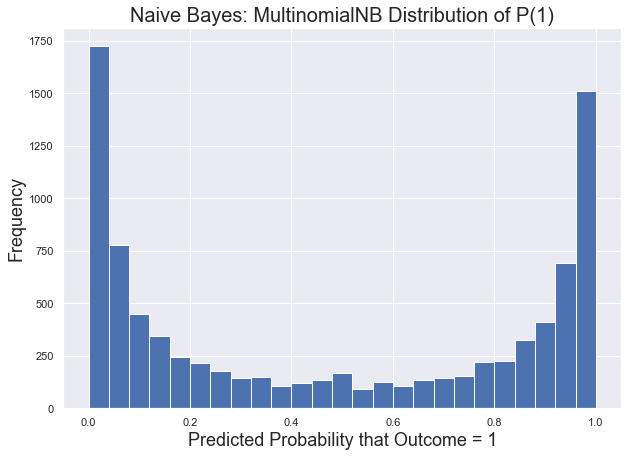

In [207]:
# Naive Bayes: Multi Dist

# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(clf_pred_df['pred_probs'], bins = 25)

# Label axes.
plt.title('Naive Bayes: MultinomialNB Distribution of P(1)', fontsize = 20)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18);

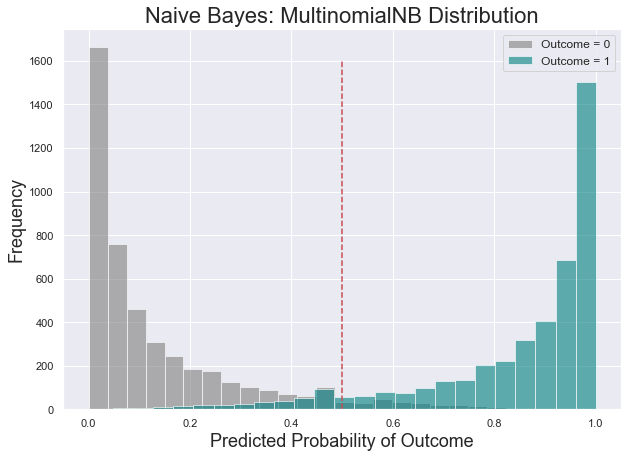

In [208]:
# Naive Bayes: Multi Dist (both outcomes)

# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(clf_pred_df[clf_pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'gray',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(clf_pred_df[clf_pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'teal',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 1600,
           color = 'r',
           linestyle = '--')

# Label axes.
plt.title('Naive Bayes: MultinomialNB Distribution', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability of Outcome', fontsize = 18)

# Create legend.
plt.legend(fontsize = 12);

#### Confusion Matrix

In [209]:
clf_preds = mnb_clr.predict(vectors_test)

In [210]:
type(clf_preds)

numpy.ndarray

In [211]:
clf_preds

array([0, 1, 1, ..., 0, 0, 1])

In [212]:
# Generate confustion matrix

cm = confusion_matrix(y_test, # True values.
                 clf_preds) 
cm

array([[4368,  232],
       [ 345, 3954]])

In [213]:
cm_df = pd.DataFrame(cm, index=['actual_whole30', 'actual_indianfood'], 
                    columns=[ 'pred_whole30', 'pred_indianfood'])
cm_df

,pred_whole30,pred_indianfood
actual_whole30,4368,232
actual_indianfood,345,3954


In [214]:
tn, fp, fn, tp = confusion_matrix(y_test, clf_preds).ravel()

In [215]:
# What is the test specificity of our model?

spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.9496


In [216]:
# What is the test sensitivity of our model?

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9197
